<a href="https://colab.research.google.com/github/tcheskko/TimeSeries_OceanAtmo/blob/main/OceanAtmoTimeSeries_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import math

from pandas.plotting import autocorrelation_plot
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from IPython.display import Image

%matplotlib inline
pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore")

In [2]:
from google.colab import files
uploaded = files.upload()

Saving OceanoAtmosferaDataSet.csv to OceanoAtmosferaDataSet.csv


#Ajustes no dataset 'OceanoAtmosferaDataSet'

In [3]:
dfOceanAtmo = pd.read_csv("OceanoAtmosferaDataSet.csv")

In [4]:
dfOceanAtmo.head(10)

,DATE,PIR_SSS,PIR_DYN,PIR_PREC,PIR_SST,PIR_WSPD,PIR_WDIR,PIR_WDIRCR,INM_PREC_TOTAL,INM_TEMP_BSE,INM_UMID_AR,INM_VENT_DIR,INM_VENT_VEL,INM_VENT_DROS
0,2018-01-01,37.21,98.63,0.00,26.61,3.40,199.10,WSW,0.00,25.70,73.00,359.00,2.70,SW
1,2018-01-02,37.22,99.70,0.00,26.65,3.40,190.20,S,0.00,26.70,73.00,354.00,1.40,ENE
2,2018-01-03,37.21,100.37,-0.04,26.61,4.20,206.20,WSW,0.00,24.90,66.00,126.00,2.00,ENE
3,2018-01-04,37.20,99.70,-0.02,26.68,3.70,196.20,WSW,0.00,26.80,54.00,294.00,1.70,SSW
4,2018-01-05,37.20,99.59,-0.02,26.74,3.60,229.30,W,0.00,26.60,63.00,337.00,2.90,SW
5,2018-01-06,37.20,99.57,-0.03,26.77,4.00,266.50,WNW,0.00,28.40,57.00,11.00,1.90,SW
6,2018-01-07,37.20,99.78,0.02,26.80,3.20,264.10,WNW,0.00,24.80,61.00,158.00,4.10,WSW
7,2018-01-08,37.20,99.87,0.00,26.80,4.00,276.60,WNW,0.00,23.00,71.00,162.00,1.80,S
8,2018-01-09,37.21,99.74,-0.02,26.83,4.90,295.30,NW,0.00,21.70,90.00,194.00,1.50,S
9,2018-01-10,37.21,99.75,0.17,26.94,3.80,294.50,NW,3.80,22.10,92.00,6.00,0.90,SW


In [5]:
dfOceanAtmo.set_index('DATE', inplace=True)

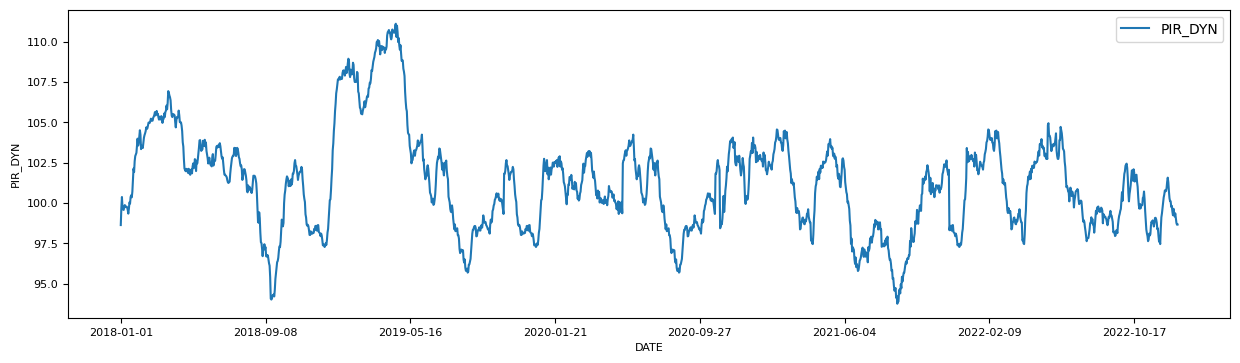

In [6]:
dfOceanAtmo.plot(y='PIR_DYN', subplots=True, figsize=(15, 4), fontsize=8)
plt.xlabel('DATE', fontsize=8)
plt.ylabel('PIR_DYN', fontsize=8)
plt.show()

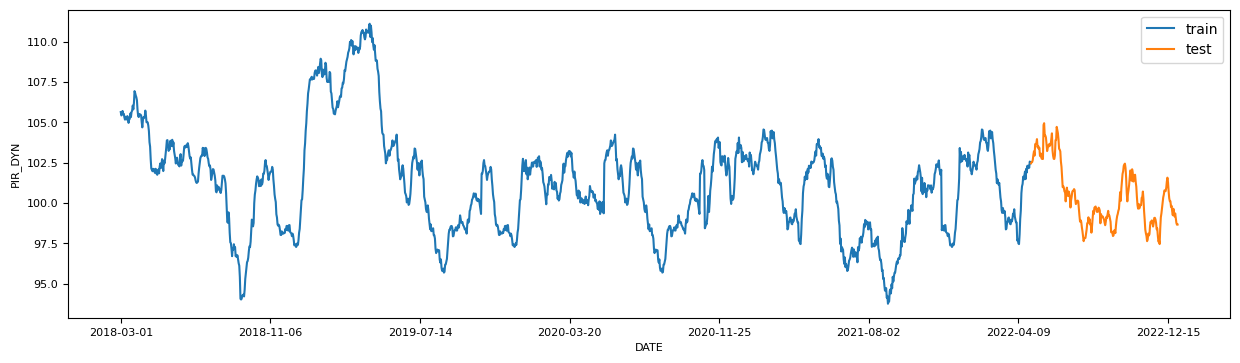

In [7]:
train_start_dt = '2018-03-01'
test_start_dt = '2022-04-30'

dfOceanAtmo[(dfOceanAtmo.index < test_start_dt) & (dfOceanAtmo.index >= train_start_dt)][['PIR_DYN']].rename(columns={'PIR_DYN':'train'}) \
    .join(dfOceanAtmo[test_start_dt:][['PIR_DYN']].rename(columns={'PIR_DYN':'test'}), how='outer') \
    .plot(y=['train', 'test'], figsize=(15, 4), fontsize=8)
plt.xlabel('DATE', fontsize=8)
plt.ylabel('PIR_DYN', fontsize=8)
plt.show()

In [8]:
train_dyn = dfOceanAtmo.copy()[(dfOceanAtmo.index >= train_start_dt) & (dfOceanAtmo.index < test_start_dt)][['PIR_DYN']]
test_dyn = dfOceanAtmo.copy()[dfOceanAtmo.index >= test_start_dt][['PIR_DYN']]

print('Training data shape: ', train_dyn.shape)
print('Test data shape: ', test_dyn.shape)

Training data shape:  (1521, 1)
Test data shape:  (246, 1)


In [9]:
scaler = MinMaxScaler()
train_dyn['PIR_DYN'] = scaler.fit_transform(train_dyn)
test_dyn['PIR_DYN'] = scaler.transform(test_dyn)


#[PIR_DYN] Dynamic Sea Surface

In [10]:
# Criando time-steps
# Para o SVR, os dados de entrada são transformados para o formato [lote x intervalo]

# Converting to numpy arrays
train_data_dyn = train_dyn.values
test_data_dyn = test_dyn.values

In [11]:
timesteps=5

In [12]:
#Converting training data to 2D tensor using nested list comprehension:

train_data_timesteps_dyn = np.array([[j for j in train_data_dyn[i:i+timesteps]] for i in range(0,len(train_data_dyn)-timesteps+1)])[:,:,0]
train_data_timesteps_dyn.shape

(1517, 5)

In [13]:
#Converting testing data to 2D tensor:

test_data_timesteps_dyn = np.array([[j for j in test_data_dyn[i:i+timesteps]] for i in range(0,len(test_data_dyn)-timesteps+1)])[:,:,0]
test_data_timesteps_dyn.shape

(242, 5)

In [14]:
#Selecting inputs and outputs from training and testing data:

x_train_dyn, y_train_dyn = train_data_timesteps_dyn[:,:timesteps-1],train_data_timesteps_dyn[:,[timesteps-1]]
x_test_dyn, y_test_dyn = test_data_timesteps_dyn[:,:timesteps-1],test_data_timesteps_dyn[:,[timesteps-1]]

print(x_train_dyn.shape, y_train_dyn.shape)
print(x_test_dyn.shape, y_test_dyn.shape)



(1517, 4) (1517, 1)
(242, 4) (242, 1)


### Implementação do modelo SVR
* Definição do modelo chamando SVR() e passando os hiperparametros kernel, gamma, c e epsilon
* Preparação do modelo e treinamento dos dados chamando a função fit()
* Gerar previsões chamando a função predict()

In [15]:
#Create SVR model. Use RBF kernel - set the hyperparameters: gamma, C and epsilon (0.5, 10, 0.05)
model_dyn = SVR(kernel='rbf',gamma=0.5, C=10, epsilon = 0.05)


In [16]:
#fit on trainning
model_dyn.fit(x_train_dyn, y_train_dyn[:,0])

SVR(C=10, epsilon=0.05, gamma=0.5)

In [17]:
#predictions
y_train_pred_dyn = model_dyn.predict(x_train_dyn).reshape(-1,1)
y_test_pred_dyn = model_dyn.predict(x_test_dyn).reshape(-1,1)

print(y_train_pred_dyn.shape, y_test_pred_dyn.shape)

(1517, 1) (242, 1)


###Avaliação do modelo
* Retorno dos dados a escala original
* plotar o grafico da serie original e prevista para analise de performance
* Validação MAPE

In [18]:
#ReScaling orginial and predicted

#predictions
y_train_pred_dyn = scaler.inverse_transform(y_train_pred_dyn)
y_test_pred_dyn = scaler.inverse_transform(y_test_pred_dyn)

print(len(y_train_pred_dyn), len(y_test_pred_dyn))

1517 242


In [19]:
#original
y_train_dyn = scaler.inverse_transform(y_train_dyn)
y_test_dyn = scaler.inverse_transform(y_test_dyn)

print(len(y_train_dyn), len(y_test_dyn))

1517 242


In [20]:
#model performance on training and test data
train_timestamps_dyn = dfOceanAtmo[(dfOceanAtmo.index < test_start_dt) & (dfOceanAtmo.index >= train_start_dt)].index[timesteps-1:]
test_timestamps_dyn = dfOceanAtmo[test_start_dt:].index[timesteps-1:]


print(len(train_timestamps_dyn), len(test_timestamps_dyn))

1517 242


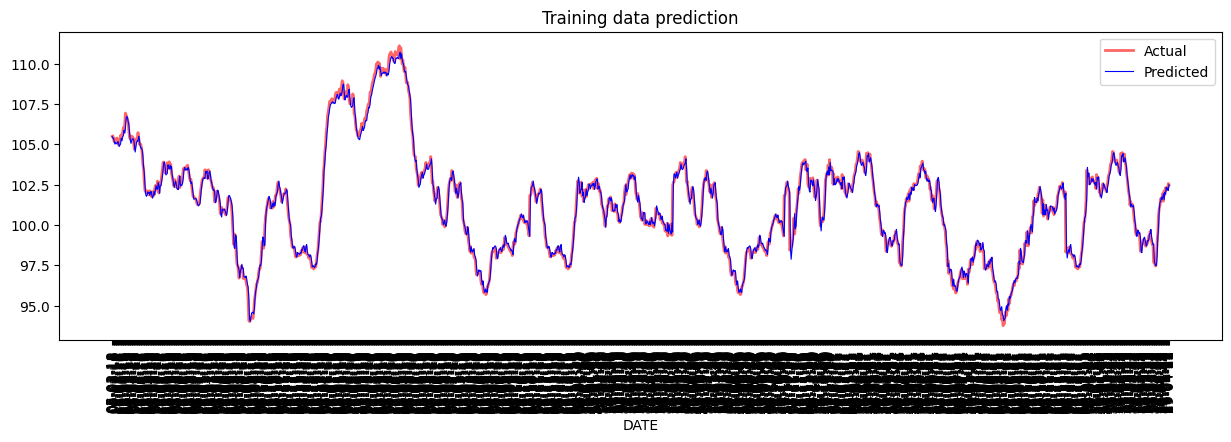

In [21]:
plt.figure(figsize=(15,4))
plt.plot(train_timestamps_dyn, y_train_dyn, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(train_timestamps_dyn, y_train_pred_dyn, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('DATE')
plt.xticks(train_timestamps_dyn, pd.to_datetime(train_timestamps_dyn).strftime('%d-%m-%y'), rotation=90)
plt.title("Training data prediction")
plt.show()

In [22]:
def mape(predictions, actuals):
    """Mean absolute percentage error"""
    return ((predictions - actuals).abs() / actuals).mean()

In [76]:
print('MAPE for training data: ', mape(pd.DataFrame(y_test_pred_dyn),pd.DataFrame(y_test_dyn))*100, '%')

MAPE for training data:  0   0.28
dtype: float64 %


<Axes: xlabel='DATE'>

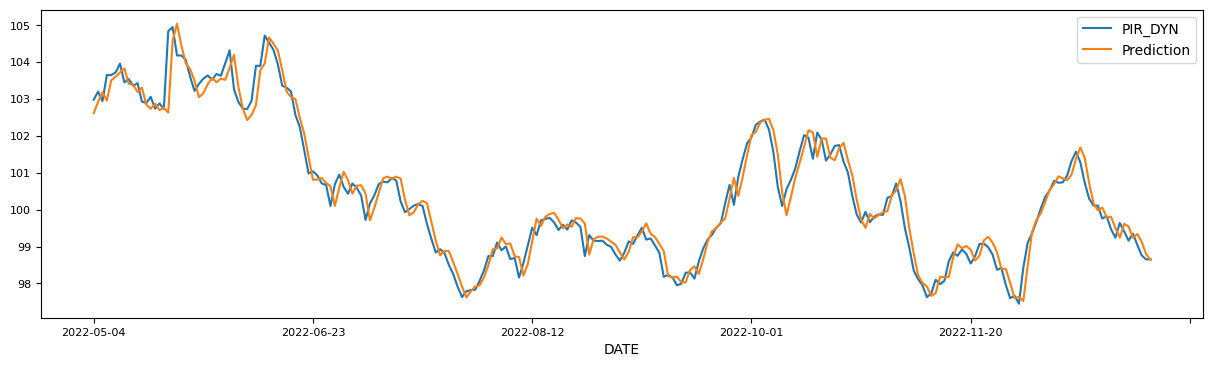

In [73]:
listY_dyn = pd.DataFrame(y_test_dyn.tolist(), columns=['PIR_DYN'])
listY_pred_dyn = pd.DataFrame(y_test_pred_dyn.tolist(), columns=['Prediction'])
listX_idx_dyn = pd.DataFrame(test_timestamps_dyn.tolist(), columns=['DATE'])


dfFull_dyn = pd.concat([listX_idx_dyn, listY_dyn, listY_pred_dyn], axis=1);
dfFull_dyn.set_index('DATE', inplace=True)

dfFull_dyn.plot(figsize=(15, 4), fontsize=8)

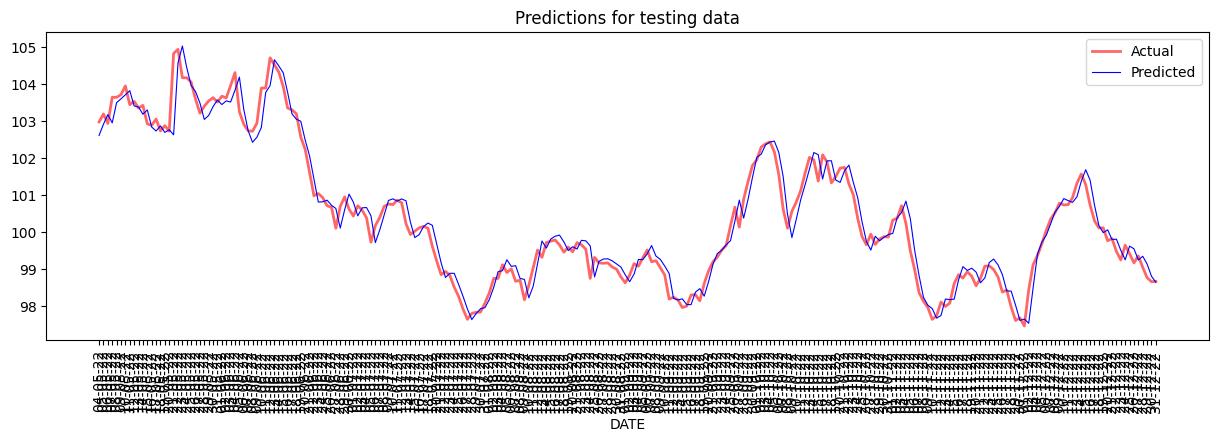

In [24]:
plt.figure(figsize=(15,4))
plt.plot(test_timestamps_dyn, y_test_dyn, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(test_timestamps_dyn, y_test_pred_dyn, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('DATE')
plt.xticks(test_timestamps_dyn, pd.to_datetime(test_timestamps_dyn).strftime('%d-%m-%y'), rotation=90)
plt.title("Predictions for testing data")
plt.show()

###Full dataset prediction

In [25]:
full_dyn_indexes = dfOceanAtmo.index.values
full_dyn_indexes_X = np.array([[j for j in full_dyn_indexes[i:i+timesteps]] for i in range(0,len(full_dyn_indexes)-timesteps+1)])[:,0]

full_dyn = dfOceanAtmo[['PIR_DYN']].values
full_dyn = scaler.fit_transform(full_dyn)

# Transforming to 2D tensor as per model input requirement
data_timesteps_dyn = np.array([[j for j in full_dyn[i:i+timesteps]] for i in range(0,len(full_dyn)-timesteps+1)])[:,:,0]
print("Tensor shape: ", data_timesteps_dyn.shape)

# Selecting inputs and outputs from data
X_dyn, Y_dyn = data_timesteps_dyn[:,:timesteps-1],data_timesteps_dyn[:,[timesteps-1]]

print("X shape: ", X_dyn.shape,"\nY shape: ", Y_dyn.shape)
print("X index: ", full_dyn_indexes_X.shape)


Tensor shape:  (1822, 5)
X shape:  (1822, 4) 
Y shape:  (1822, 1)
X index:  (1822,)


In [26]:
# Make model predictions
Y_pred_dyn = model_dyn.predict(X_dyn).reshape(-1,1)

# Inverse scale and reshape
Y_pred_dyn = scaler.inverse_transform(Y_pred_dyn)
Y_dyn = scaler.inverse_transform(Y_dyn)

<Axes: xlabel='DATE'>

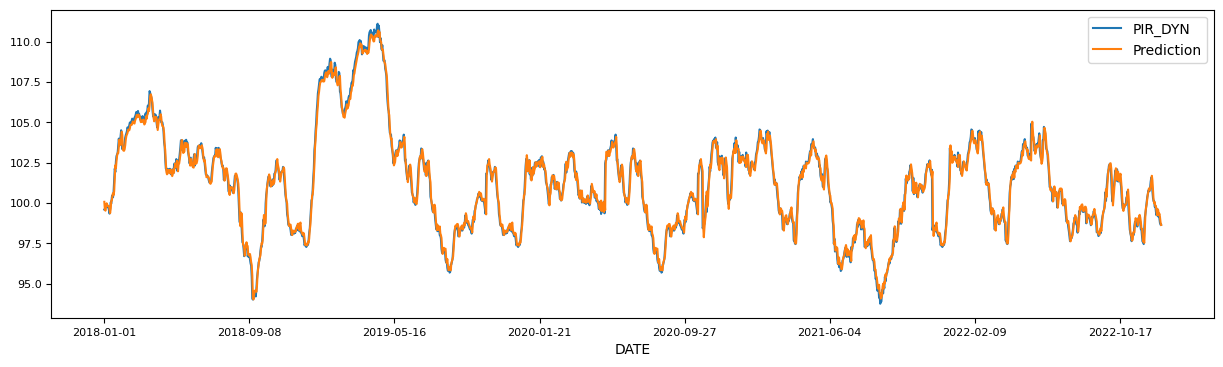

In [27]:
listY_dyn = pd.DataFrame(Y_dyn.tolist(), columns=['PIR_DYN'])
listY_pred_dyn = pd.DataFrame(Y_pred_dyn.tolist(), columns=['Prediction'])
listX_idx_dyn = pd.DataFrame(full_dyn_indexes_X.tolist(), columns=['DATE'])


dfFull = pd.concat([listX_idx_dyn, listY_dyn, listY_pred_dyn], axis=1);
dfFull.set_index('DATE', inplace=True)

dfFull.plot(figsize=(15, 4), fontsize=8)


#[PIR_SST] Sea Surface Temperature


In [28]:
train_sst = dfOceanAtmo.copy()[(dfOceanAtmo.index >= train_start_dt) & (dfOceanAtmo.index < test_start_dt)][['PIR_SST']]
test_sst = dfOceanAtmo.copy()[dfOceanAtmo.index >= test_start_dt][['PIR_SST']]

print('Training data shape: ', train_sst.shape)
print('Test data shape: ', test_sst.shape)

Training data shape:  (1521, 1)
Test data shape:  (246, 1)


In [29]:
train_sst['PIR_SST'] = scaler.fit_transform(train_sst)
test_sst['PIR_SST'] = scaler.transform(test_sst)

In [30]:
# Criando time-steps
# Para o SVR, os dados de entrada são transformados para o formato [lote x intervalo]
# Converting to numpy arrays
train_data_sst = train_sst.values
test_data_sst = test_sst.values

In [31]:
#Converting training data to 2D tensor using nested list comprehension:
train_data_timesteps_sst = np.array([[j for j in train_data_sst[i:i+timesteps]] for i in range(0,len(train_data_sst)-timesteps+1)])[:,:,0]
train_data_timesteps_sst.shape

(1517, 5)

In [32]:
#Converting testing data to 2D tensor:
test_data_timesteps_sst = np.array([[j for j in test_data_sst[i:i+timesteps]] for i in range(0,len(test_data_sst)-timesteps+1)])[:,:,0]
test_data_timesteps_sst.shape

(242, 5)

In [33]:
#Selecting inputs and outputs from training and testing data:
x_train_sst, y_train_sst = train_data_timesteps_sst[:,:timesteps-1],train_data_timesteps_sst[:,[timesteps-1]]
x_test_sst, y_test_sst = test_data_timesteps_sst[:,:timesteps-1],test_data_timesteps_sst[:,[timesteps-1]]

print(x_train_sst.shape, y_train_sst.shape)
print(x_test_sst.shape, y_test_sst.shape)

(1517, 4) (1517, 1)
(242, 4) (242, 1)


### Implementação do modelo SVR
* Definição do modelo chamando SVR() e passando os hiperparametros kernel, gamma, c e epsilon
* Preparação do modelo e treinamento dos dados chamando a função fit()
* Gerar previsões chamando a função predict()

In [34]:
#Create SVR model. Use RBF kernel - set the hyperparameters: gamma, C and epsilon (0.5, 10, 0.05)
model_sst = SVR(kernel='rbf',gamma=0.5, C=10, epsilon = 0.05)

#fit and trainning
model_sst.fit(x_train_sst, y_train_sst[:,0])

SVR(C=10, epsilon=0.05, gamma=0.5)

In [35]:
#predictions
y_train_pred_sst = model_sst.predict(x_train_sst).reshape(-1,1)
y_test_pred_sst = model_sst.predict(x_test_sst).reshape(-1,1)

print(y_train_pred_sst.shape, y_test_pred_sst.shape)

(1517, 1) (242, 1)


###Avaliação do modelo
* Retorno dos dados a escala original
* plotar o grafico da serie original e prevista para analise de performance
* Validação MAPE

In [36]:
#ReScaling predictions
y_train_pred_sst = scaler.inverse_transform(y_train_pred_sst)
y_test_pred_sst = scaler.inverse_transform(y_test_pred_sst)

#ReScaling original
y_train_sst = scaler.inverse_transform(y_train_sst)
y_test_sst = scaler.inverse_transform(y_test_sst)

#model performance on training and test data
train_timestamps_sst = dfOceanAtmo[(dfOceanAtmo.index < test_start_dt) & (dfOceanAtmo.index >= train_start_dt)].index[timesteps-1:]
test_timestamps_sst = dfOceanAtmo[test_start_dt:].index[timesteps-1:]

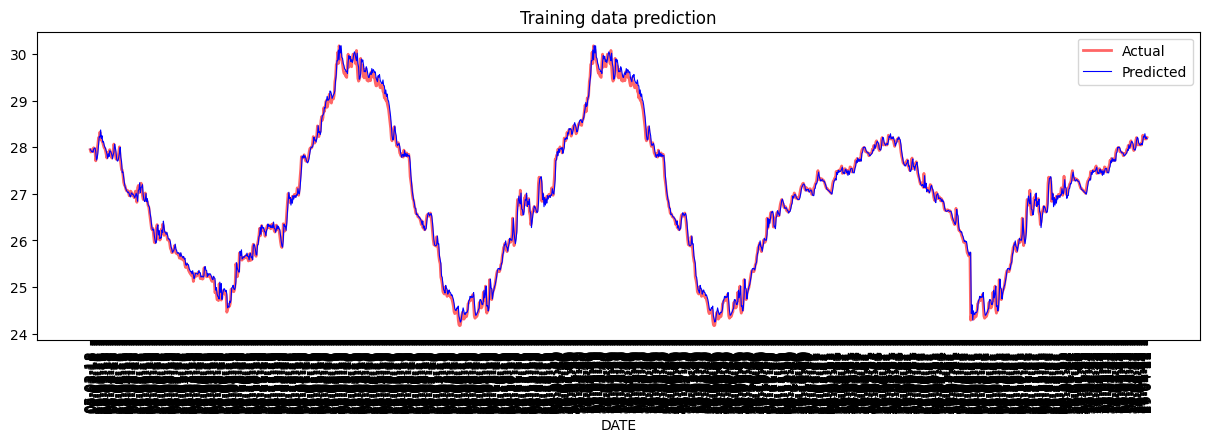

In [37]:
plt.figure(figsize=(15,4))
plt.plot(train_timestamps_sst, y_train_sst, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(train_timestamps_sst, y_train_pred_sst, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('DATE')
plt.xticks(train_timestamps_sst, pd.to_datetime(train_timestamps_sst).strftime('%d-%m-%y'), rotation=90)
plt.title("Training data prediction")
plt.show()

In [77]:
print('MAPE for training data: ', mape(pd.DataFrame(y_test_pred_sst), pd.DataFrame(y_test_sst))*100, '%')

MAPE for training data:  0   0.36
dtype: float64 %


<Axes: xlabel='DATE'>

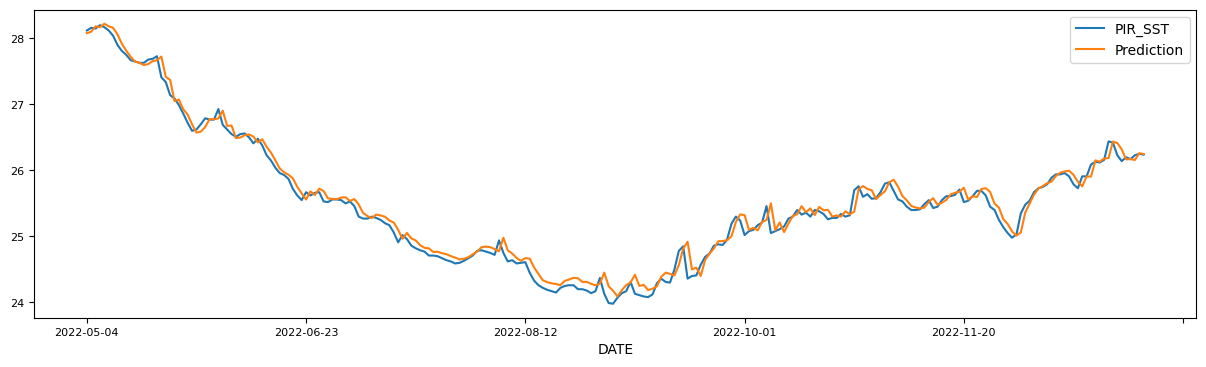

In [75]:
listY_sst = pd.DataFrame(y_test_sst.tolist(), columns=['PIR_SST'])
listY_pred_sst = pd.DataFrame(y_test_pred_sst.tolist(), columns=['Prediction'])
listX_idx_sst = pd.DataFrame(test_timestamps_sst.tolist(), columns=['DATE'])


dfTrain_sst = pd.concat([listX_idx_sst, listY_sst, listY_pred_sst], axis=1);
dfTrain_sst.set_index('DATE', inplace=True)

dfTrain_sst.plot(figsize=(15, 4), fontsize=8)

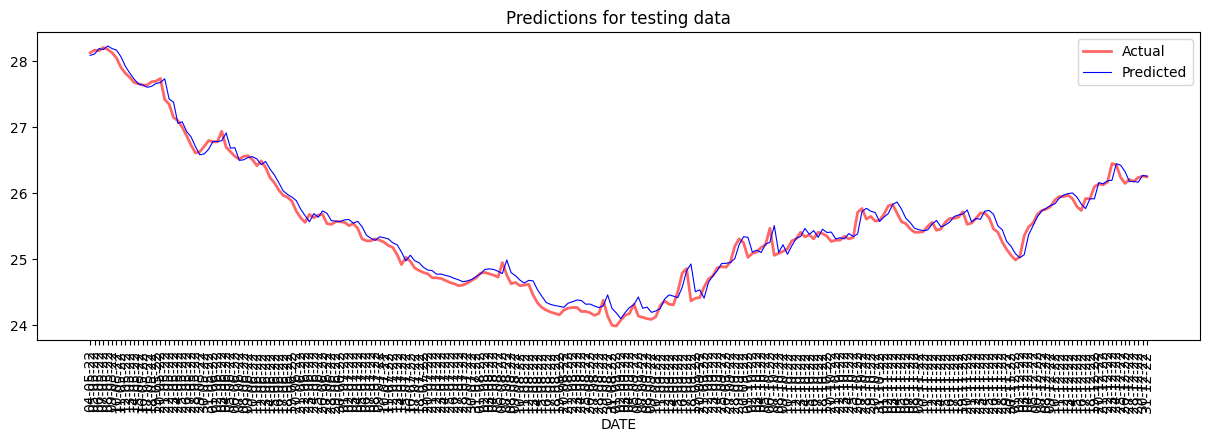

In [39]:
plt.figure(figsize=(15,4))
plt.plot(test_timestamps_sst, y_test_sst, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(test_timestamps_sst, y_test_pred_sst, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('DATE')
plt.xticks(test_timestamps_sst, pd.to_datetime(test_timestamps_sst).strftime('%d-%m-%y'), rotation=90)
plt.title("Predictions for testing data")
plt.show()

###Full dataset prediction

In [40]:
full_sst_indexes = dfOceanAtmo.index.values
full_sst_indexes_X = np.array([[j for j in full_sst_indexes[i:i+timesteps]] for i in range(0,len(full_sst_indexes)-timesteps+1)])[:,0]

full_sst = dfOceanAtmo[['PIR_SST']].values
full_sst = scaler.fit_transform(full_sst)

# Transforming to 2D tensor as per model input requirement
data_timesteps_sst = np.array([[j for j in full_sst[i:i+timesteps]] for i in range(0,len(full_sst)-timesteps+1)])[:,:,0]
print("Tensor shape: ", data_timesteps_sst.shape)

# Selecting inputs and outputs from data
X_sst, Y_sst = data_timesteps_sst[:,:timesteps-1],data_timesteps_sst[:,[timesteps-1]]

print("X shape: ", X_sst.shape,"\nY shape: ", Y_sst.shape)
print("X index: ", full_sst_indexes_X.shape)

Tensor shape:  (1822, 5)
X shape:  (1822, 4) 
Y shape:  (1822, 1)
X index:  (1822,)


In [41]:
# Make model predictions
Y_pred_sst = model_sst.predict(X_sst).reshape(-1,1)

# Inverse scale and reshape
Y_pred_sst = scaler.inverse_transform(Y_pred_sst)
Y_sst = scaler.inverse_transform(Y_sst)

<Axes: xlabel='DATE'>

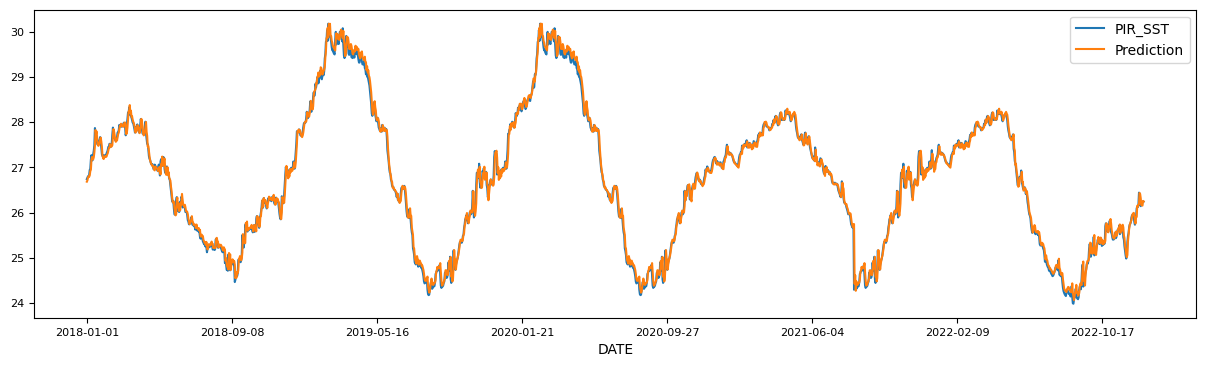

In [42]:
listY_sst = pd.DataFrame(Y_sst.tolist(), columns=['PIR_SST'])
listY_pred_sst = pd.DataFrame(Y_pred_sst.tolist(), columns=['Prediction'])
listX_idx_sst = pd.DataFrame(full_sst_indexes_X.tolist(), columns=['DATE'])


dfFull_sst = pd.concat([listX_idx_sst, listY_sst, listY_pred_sst], axis=1);
dfFull_sst.set_index('DATE', inplace=True)

dfFull_sst.plot(figsize=(15, 4), fontsize=8)

#[INM_PREC_TOTAL] Precipitação total

In [324]:
train_prt = dfOceanAtmo.copy()[(dfOceanAtmo.index >= train_start_dt) & (dfOceanAtmo.index < test_start_dt)][['INM_PREC_TOTAL']]
test_prt = dfOceanAtmo.copy()[dfOceanAtmo.index >= test_start_dt][['INM_PREC_TOTAL']]

print('Training data shape: ', train_prt.shape)
print('Test data shape: ', test_prt.shape)

Training data shape:  (1521, 1)
Test data shape:  (246, 1)


In [325]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

#from sklearn.preprocessing import RobustScaler
#rb = RobustScaler()

In [326]:
#Scaling StandardScaler
#train_prt['INM_PREC_TOTAL'] = sc.fit_transform(train_prt)
#test_prt['INM_PREC_TOTAL'] = sc.transform(test_prt)

In [327]:
#Scaling MinMaxScaler
#train_prt['INM_PREC_TOTAL'] = scaler.fit_transform(train_prt)
#test_prt['INM_PREC_TOTAL'] = scaler.transform(test_prt)

In [328]:
# Para o SVR, os dados de entrada são transformados para o formato [lote x intervalo]
# Converting to numpy arrays
train_data_prt = train_prt.values
test_data_prt = test_prt.values

In [329]:
# Criando time-steps
#Converting training data to 2D tensor using nested list comprehension:
train_data_timesteps_prt = np.array([[j for j in train_data_prt[i:i+timesteps]] for i in range(0,len(train_data_prt)-timesteps+1)])[:,:,0]
train_data_timesteps_prt.shape

(1517, 5)

In [330]:
#Converting testing data to 2D tensor:
test_data_timesteps_prt = np.array([[j for j in test_data_prt[i:i+timesteps]] for i in range(0,len(test_data_prt)-timesteps+1)])[:,:,0]
test_data_timesteps_prt.shape

(242, 5)

In [331]:
#Selecting inputs and outputs from training and testing data:
x_train_prt, y_train_prt = train_data_timesteps_prt[:,:timesteps-1],train_data_timesteps_prt[:,[timesteps-1]]
x_test_prt, y_test_prt = test_data_timesteps_prt[:,:timesteps-1],test_data_timesteps_prt[:,[timesteps-1]]

print(x_train_prt.shape, y_train_prt.shape)
print(x_test_prt.shape, y_test_prt.shape)

(1517, 4) (1517, 1)
(242, 4) (242, 1)


### Implementação do modelo SVR
* Definição do modelo chamando SVR() e passando os hiperparametros kernel, gamma, c e epsilon
* Preparação do modelo e treinamento dos dados chamando a função fit()
* Gerar previsões chamando a função predict()

In [332]:
#Create SVR model. Use RBF kernel - set the hyperparameters: gamma, C and epsilon (0.5, 10, 0.05)
model_prt = SVR(kernel='rbf',gamma=0.5, C=10, epsilon = 0.05)

#fit and trainning
model_prt.fit(x_train_prt, y_train_prt[:,0])

SVR(C=10, epsilon=0.05, gamma=0.5)

In [333]:
#predictions
y_train_pred_prt = model_prt.predict(x_train_prt).reshape(-1,1)
y_test_pred_prt = model_prt.predict(x_test_prt).reshape(-1,1)

print(y_train_pred_prt.shape, y_test_pred_prt.shape)

(1517, 1) (242, 1)


###Avaliação do modelo
* Retorno dos dados a escala original
* plotar o grafico da serie original e prevista para analise de performance
* Validação MAPE

In [334]:
#ReScaling predictions
y_train_pred_prt = scaler.inverse_transform(y_train_pred_prt)
y_test_pred_prt = scaler.inverse_transform(y_test_pred_prt)

#ReScaling original
y_train_prt = scaler.inverse_transform(y_train_prt)
y_test_prt = scaler.inverse_transform(y_test_prt)

#model performance on training and test data
train_timestamps_prt = dfOceanAtmo[(dfOceanAtmo.index < test_start_dt) & (dfOceanAtmo.index >= train_start_dt)].index[timesteps-1:]
test_timestamps_prt = dfOceanAtmo[test_start_dt:].index[timesteps-1:]

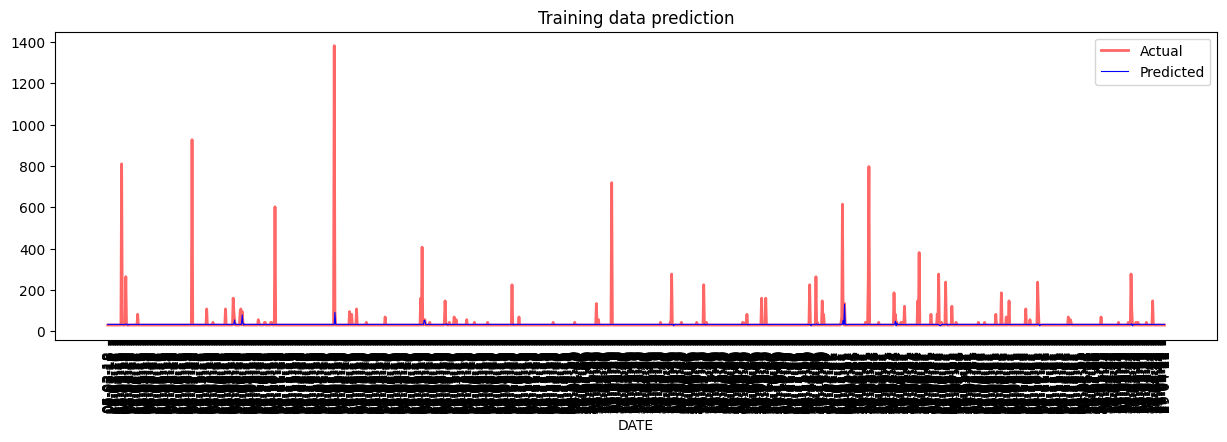

In [335]:
plt.figure(figsize=(15,4))
plt.plot(train_timestamps_prt, y_train_prt, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(train_timestamps_prt, y_train_pred_prt, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('DATE')
plt.xticks(train_timestamps_prt, pd.to_datetime(train_timestamps_prt).strftime('%d-%m-%y'), rotation=90)
plt.title("Training data prediction")
plt.show()

In [336]:
print('MAPE for training data: ', mape(pd.DataFrame(y_test_pred_prt), pd.DataFrame(y_test_prt))*100, '%')

MAPE for training data:  0   17.60
dtype: float64 %


In [337]:
#https://stephenallwright.com/calculate-mape-with-0-values/
def smape(actuals, predictions):
    return 1/len(actuals) * np.sum(2 * np.abs(predictions - actuals) / (np.abs(actuals) + np.abs(predictions)))

print('One step forecast SMAPE: ', (smape(pd.DataFrame(y_test_prt), pd.DataFrame(y_test_pred_prt))), '%')

One step forecast SMAPE:  0   0.20
dtype: float64 %


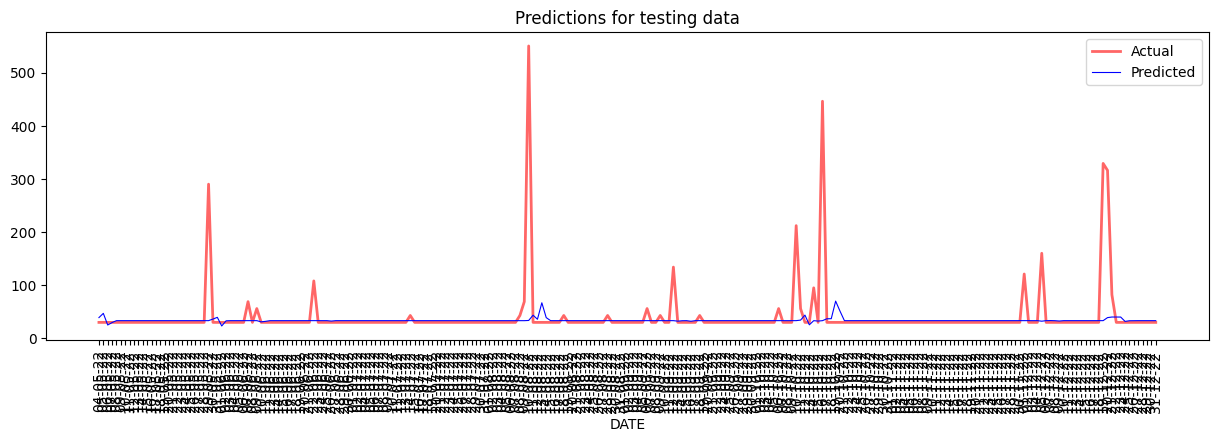

In [338]:
plt.figure(figsize=(15,4))
plt.plot(test_timestamps_prt, y_test_prt, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(test_timestamps_prt, y_test_pred_prt, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('DATE')
plt.xticks(test_timestamps_prt, pd.to_datetime(test_timestamps_prt).strftime('%d-%m-%y'), rotation=90)
plt.title("Predictions for testing data")
plt.show()

<Axes: xlabel='DATE'>

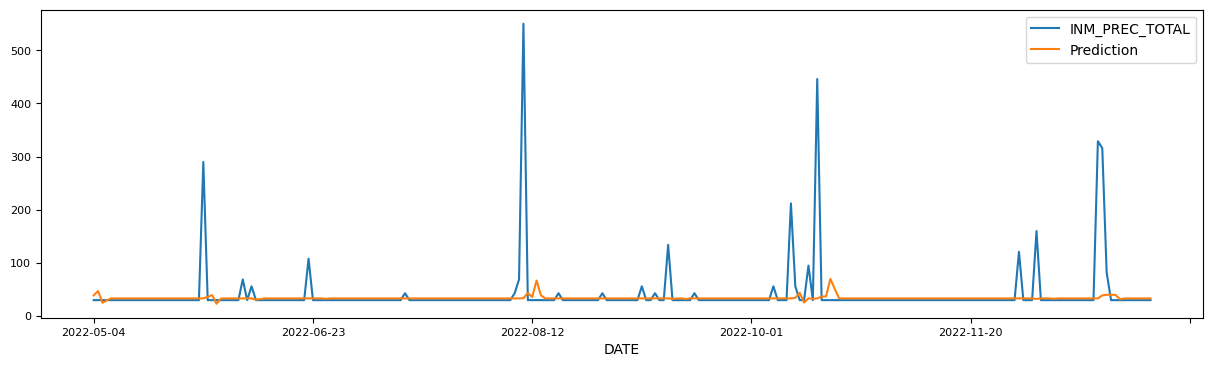

In [339]:
listY_prt = pd.DataFrame(y_test_prt.tolist(), columns=['INM_PREC_TOTAL'])
listY_pred_prt = pd.DataFrame(y_test_pred_prt.tolist(), columns=['Prediction'])
listX_idx_prt = pd.DataFrame(test_timestamps_prt.tolist(), columns=['DATE'])


dfTrain_prt = pd.concat([listX_idx_prt, listY_prt, listY_pred_prt], axis=1);
dfTrain_prt.set_index('DATE', inplace=True)

dfTrain_prt.plot(figsize=(15, 4), fontsize=8)

###Full dataset prediction

In [340]:
full_prt_indexes = dfOceanAtmo.index.values
full_prt_indexes_X = np.array([[j for j in full_prt_indexes[i:i+timesteps]] for i in range(0,len(full_prt_indexes)-timesteps+1)])[:,0]

full_prt = dfOceanAtmo[['INM_PREC_TOTAL']].values
full_prt = scaler.fit_transform(full_prt)

# Transforming to 2D tensor as per model input requirement
data_timesteps_prt = np.array([[j for j in full_prt[i:i+timesteps]] for i in range(0,len(full_prt)-timesteps+1)])[:,:,0]
print("Tensor shape: ", data_timesteps_prt.shape)

# Selecting inputs and outputs from data
X_prt, Y_prt = data_timesteps_prt[:,:timesteps-1],data_timesteps_prt[:,[timesteps-1]]

print("X shape: ", X_prt.shape,"\nY shape: ", Y_prt.shape)
print("X index: ", full_prt_indexes_X.shape)

Tensor shape:  (1822, 5)
X shape:  (1822, 4) 
Y shape:  (1822, 1)
X index:  (1822,)


In [341]:
# Make model predictions
Y_pred_prt = model_prt.predict(X_prt).reshape(-1,1)

# Inverse scale and reshape
Y_pred_prt = scaler.inverse_transform(Y_pred_prt)
Y_prt = scaler.inverse_transform(Y_prt)

<Axes: xlabel='DATE'>

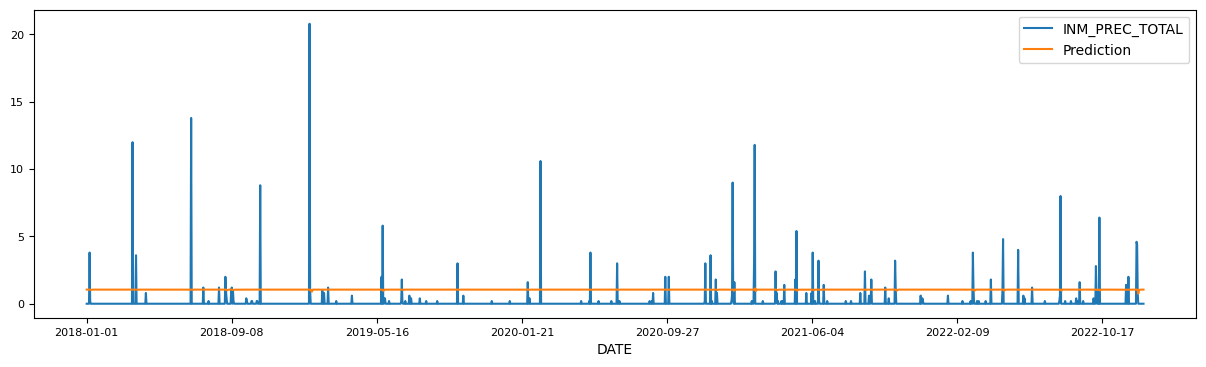

In [342]:
listY_prt = pd.DataFrame(Y_prt.tolist(), columns=['INM_PREC_TOTAL'])
listY_pred_prt = pd.DataFrame(Y_pred_prt.tolist(), columns=['Prediction'])
listX_idx_prt = pd.DataFrame(full_prt_indexes_X.tolist(), columns=['DATE'])


dfFull_prt = pd.concat([listX_idx_prt, listY_prt, listY_pred_prt], axis=1);
dfFull_prt.set_index('DATE', inplace=True)

dfFull_prt.plot(figsize=(15, 4), fontsize=8)

#[INM_UMID_AR] Umidade relativa do ar

In [343]:
train_umi = dfOceanAtmo.copy()[(dfOceanAtmo.index >= train_start_dt) & (dfOceanAtmo.index < test_start_dt)][['INM_UMID_AR']]
test_umi = dfOceanAtmo.copy()[dfOceanAtmo.index >= test_start_dt][['INM_UMID_AR']]

print('Training data shape: ', train_umi.shape)
print('Test data shape: ', test_umi.shape)

Training data shape:  (1521, 1)
Test data shape:  (246, 1)


In [344]:
train_umi['INM_UMID_AR'] = scaler.fit_transform(train_umi)
test_umi['INM_UMID_AR'] = scaler.transform(test_umi)

In [345]:
# Criando time-steps
# Para o SVR, os dados de entrada são transformados para o formato [lote x intervalo]
# Converting to numpy arrays
train_data_umi = train_umi.values
test_data_umi = test_umi.values

In [346]:
#Converting training data to 2D tensor using nested list comprehension:
train_data_timesteps_umi = np.array([[j for j in train_data_umi[i:i+timesteps]] for i in range(0,len(train_data_umi)-timesteps+1)])[:,:,0]
train_data_timesteps_umi.shape

(1517, 5)

In [347]:
#Converting testing data to 2D tensor:
test_data_timesteps_umi = np.array([[j for j in test_data_umi[i:i+timesteps]] for i in range(0,len(test_data_umi)-timesteps+1)])[:,:,0]
test_data_timesteps_umi.shape

(242, 5)

In [348]:
x_train_umi, y_train_umi = train_data_timesteps_umi[:,:timesteps-1],train_data_timesteps_umi[:,[timesteps-1]]
x_test_umi, y_test_umi = test_data_timesteps_umi[:,:timesteps-1],test_data_timesteps_umi[:,[timesteps-1]]

print(x_train_umi.shape, y_train_umi.shape)
print(x_test_umi.shape, y_test_umi.shape)

(1517, 4) (1517, 1)
(242, 4) (242, 1)


### Implementação do modelo SVR
* Definição do modelo chamando SVR() e passando os hiperparametros kernel, gamma, c e epsilon
* Preparação do modelo e treinamento dos dados chamando a função fit()
* Gerar previsões chamando a função predict()

In [349]:
#Create SVR model. Use RBF kernel - set the hyperparameters: gamma, C and epsilon (0.5, 10, 0.05)
model_umi = SVR(kernel='rbf',gamma=0.5, C=10, epsilon = 0.05)

#fit and trainning
model_umi.fit(x_train_umi, y_train_umi[:,0])

SVR(C=10, epsilon=0.05, gamma=0.5)

In [350]:
#predictions
y_train_pred_umi = model_umi.predict(x_train_umi).reshape(-1,1)
y_test_pred_umi = model_umi.predict(x_test_umi).reshape(-1,1)

print(y_train_pred_umi.shape, y_test_pred_umi.shape)

(1517, 1) (242, 1)


###Avaliação do modelo
* Retorno dos dados a escala original
* plotar o grafico da serie original e prevista para analise de performance
* Validação MAPE

In [351]:
#ReScaling predictions
y_train_pred_umi = scaler.inverse_transform(y_train_pred_umi)
y_test_pred_umi = scaler.inverse_transform(y_test_pred_umi)

#ReScaling original
y_train_umi = scaler.inverse_transform(y_train_umi)
y_test_umi = scaler.inverse_transform(y_test_umi)

#model performance on training and test data
train_timestamps_umi = dfOceanAtmo[(dfOceanAtmo.index < test_start_dt) & (dfOceanAtmo.index >= train_start_dt)].index[timesteps-1:]
test_timestamps_umi = dfOceanAtmo[test_start_dt:].index[timesteps-1:]

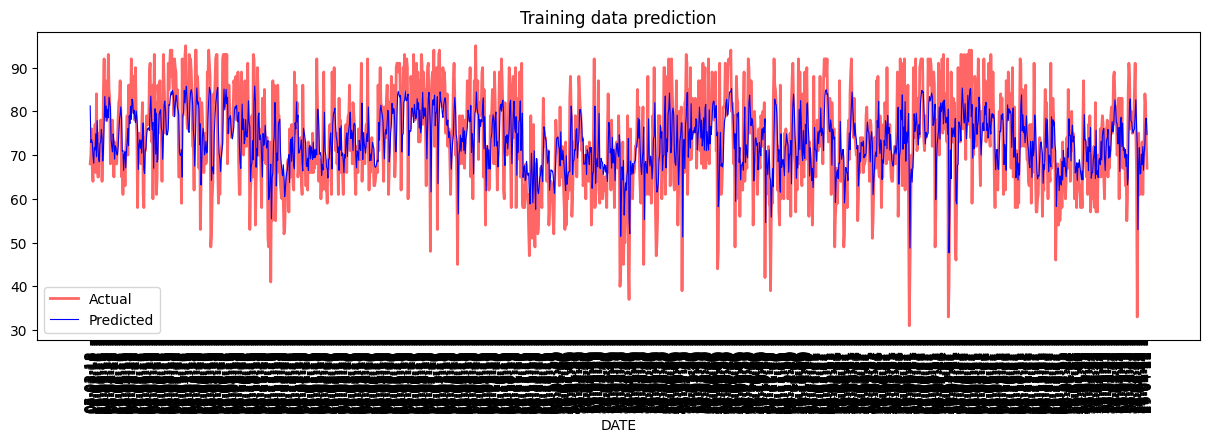

In [352]:
plt.figure(figsize=(15,4))
plt.plot(train_timestamps_umi, y_train_umi, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(train_timestamps_umi, y_train_pred_umi, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('DATE')
plt.xticks(train_timestamps_umi, pd.to_datetime(train_timestamps_umi).strftime('%d-%m-%y'), rotation=90)
plt.title("Training data prediction")
plt.show()

In [360]:
print('MAPE for training data: ', mape(pd.DataFrame(y_test_pred_umi), pd.DataFrame(y_test_umi))*100, '%')

MAPE for training data:  0   12.44
dtype: float64 %


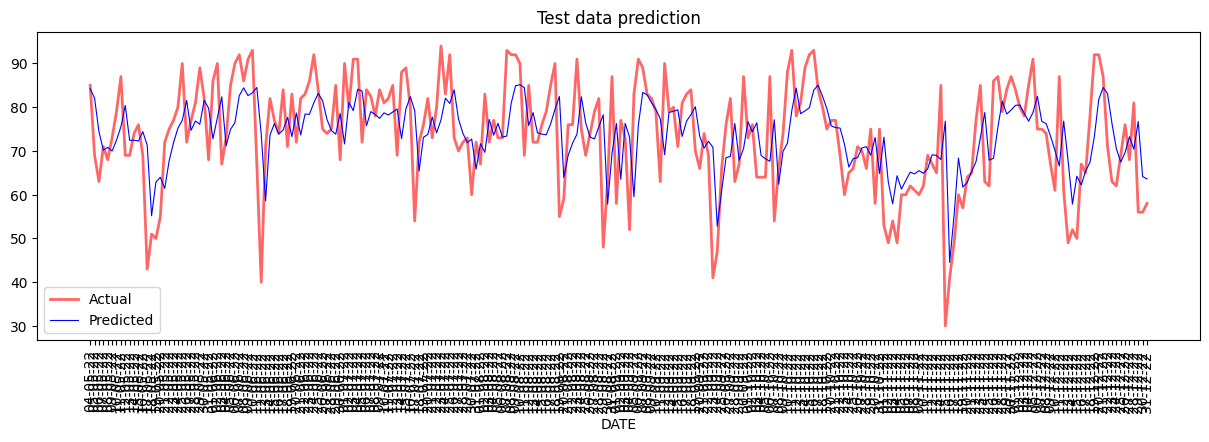

In [354]:
plt.figure(figsize=(15,4))
plt.plot(test_timestamps_umi, y_test_umi, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(test_timestamps_umi, y_test_pred_umi, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('DATE')
plt.xticks(test_timestamps_umi, pd.to_datetime(test_timestamps_umi).strftime('%d-%m-%y'), rotation=90)
plt.title("Test data prediction")
plt.show()

<Axes: xlabel='DATE'>

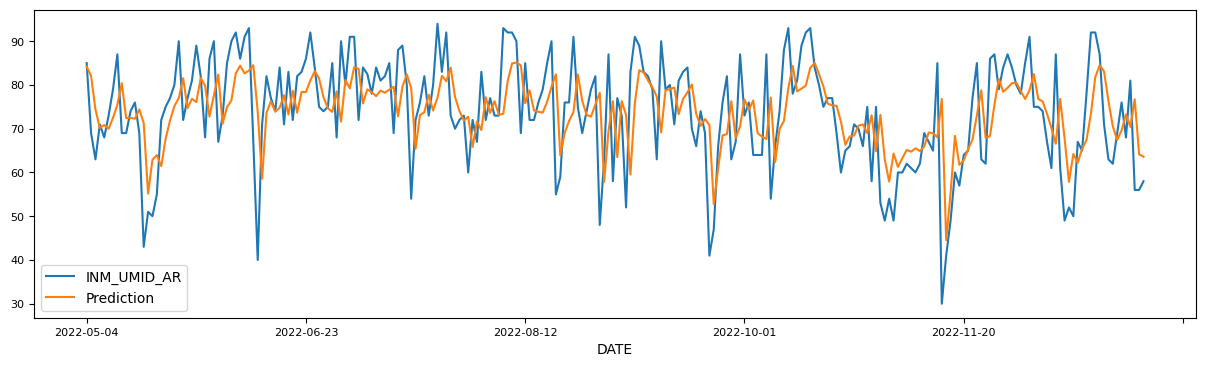

In [359]:
listY_umi = pd.DataFrame(y_test_umi.tolist(), columns=['INM_UMID_AR'])
listY_pred_umi = pd.DataFrame(y_test_pred_umi.tolist(), columns=['Prediction'])
listX_idx_umi = pd.DataFrame(test_timestamps_umi.tolist(), columns=['DATE'])


dfTrain_umi = pd.concat([listX_idx_umi, listY_umi, listY_pred_umi], axis=1);
dfTrain_umi.set_index('DATE', inplace=True)

dfTrain_umi.plot(figsize=(15, 4), fontsize=8)

###Full dataset prediction

In [355]:
full_umi_indexes = dfOceanAtmo.index.values
full_umi_indexes_X = np.array([[j for j in full_umi_indexes[i:i+timesteps]] for i in range(0,len(full_umi_indexes)-timesteps+1)])[:,0]

full_umi = dfOceanAtmo[['INM_UMID_AR']].values
full_umi = scaler.fit_transform(full_umi)

# Transforming to 2D tensor as per model input requirement
data_timesteps_umi = np.array([[j for j in full_umi[i:i+timesteps]] for i in range(0,len(full_umi)-timesteps+1)])[:,:,0]
print("Tensor shape: ", data_timesteps_umi.shape)

# Selecting inputs and outputs from data
X_umi, Y_umi = data_timesteps_umi[:,:timesteps-1],data_timesteps_umi[:,[timesteps-1]]

print("X shape: ", X_umi.shape,"\nY shape: ", Y_umi.shape)
print("X index: ", full_umi_indexes_X.shape)

Tensor shape:  (1822, 5)
X shape:  (1822, 4) 
Y shape:  (1822, 1)
X index:  (1822,)


In [356]:
# Make model predictions
Y_pred_umi = model_umi.predict(X_umi).reshape(-1,1)

# Inverse scale and reshape
Y_pred_umi = scaler.inverse_transform(Y_pred_umi)
Y_umi = scaler.inverse_transform(Y_umi)

<Axes: xlabel='DATE'>

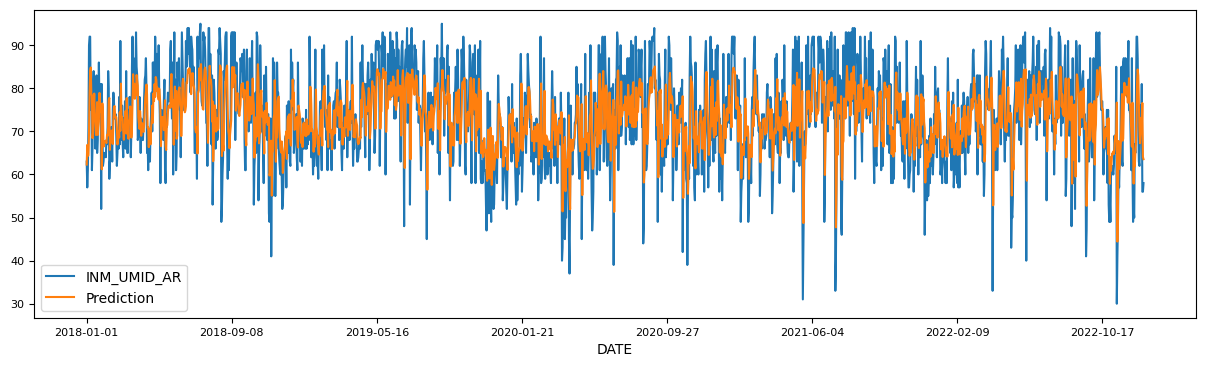

In [357]:
listY_umi = pd.DataFrame(Y_umi.tolist(), columns=['INM_UMID_AR'])
listY_pred_umi = pd.DataFrame(Y_pred_umi.tolist(), columns=['Prediction'])
listX_idx_umi = pd.DataFrame(full_umi_indexes_X.tolist(), columns=['DATE'])


dfFull_umi = pd.concat([listX_idx_umi, listY_umi, listY_pred_umi], axis=1);
dfFull_umi.set_index('DATE', inplace=True)

dfFull_umi.plot(figsize=(15, 4), fontsize=8)